In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import re

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- Configuration ---
# Set the base directory containing the 'SW-Generation-w-Tooling' folder
# Adjust this if your notebook is not in the parent directory of 'SW-Generation-w-Tooling'
BASE_SEARCH_DIR = Path('./')
RESULTS_DIR_PATTERN = 'results_*' # Pattern for results directories
TARGET_MODEL_PREFIXES = ['gemini', 'nvidia', 'vertex_gemma'] # Prefixes for CSVs to include
EXCLUDED_MODEL_PREFIX = 'gemma' # Prefixes for CSVs to explicitly exclude

OUTPUT_FILENAME = 'incorrectly_answered_questions_consolidated.csv'

# Define the core columns we expect to keep for each unique question
CORE_INFO_COLS = ['dataset', 'id', 'question', 'ground_truth_answer', 'ground_truth_explanation']

print(f"Base search directory: {BASE_SEARCH_DIR.resolve()}")
print(f"Target model prefixes: {TARGET_MODEL_PREFIXES}")
print(f"Excluded model prefix: {EXCLUDED_MODEL_PREFIX}")
print(f"Output file: {OUTPUT_FILENAME}")

Base search directory: /Users/rafraf/Documents/code/MIT/SW-Generation-w-Tooling/Phase 0
Target model prefixes: ['gemini', 'nvidia', 'vertex_gemma']
Excluded model prefix: gemma
Output file: incorrectly_answered_questions_consolidated.csv


In [3]:
csv_files_to_process = []
search_path = BASE_SEARCH_DIR / '**' / RESULTS_DIR_PATTERN / '*.csv'

# Use glob to recursively find files matching the pattern
# Using ** requires recursive=True in glob, or use pathlib's rglob
print(f"Searching for CSV files matching pattern: {search_path}")

all_csvs_in_results_dirs = list(BASE_SEARCH_DIR.rglob(f'{RESULTS_DIR_PATTERN}/*.csv'))
print(f"Found {len(all_csvs_in_results_dirs)} total CSV files within directories matching '{RESULTS_DIR_PATTERN}'.")

for file_path in all_csvs_in_results_dirs:
    filename = file_path.name
    # Check if the filename starts with any of the target prefixes
    is_target = any(filename.startswith(f"{prefix}_results_") for prefix in TARGET_MODEL_PREFIXES)
    # Check if the filename starts with the excluded prefix
    is_excluded = filename.startswith(f"{EXCLUDED_MODEL_PREFIX}_results_")

    if is_target and not is_excluded:
        csv_files_to_process.append(file_path)
        # print(f"  -> Including: {file_path}")
    # else:
        # print(f"  -> Skipping: {file_path} (Is Target: {is_target}, Is Excluded: {is_excluded})")


print(f"\nFound {len(csv_files_to_process)} relevant CSV files to process:")
for f in csv_files_to_process:
    print(f"- {f}")

Searching for CSV files matching pattern: **/results_*/*.csv
Found 37 total CSV files within directories matching 'results_*'.

Found 36 relevant CSV files to process:
- results_2025-04-23_19-09-49/gemini_results_mmlu_clinical_knowledge.csv
- results_2025-04-23_19-09-49/nvidia_results_mmlu_clinical_knowledge.csv
- results_2025-04-23_10-08-44/gemini_results_mmlu_clinical_knowledge.csv
- results_2025-04-23_10-08-44/nvidia_results_mmlu_clinical_knowledge.csv
- results_2025-04-23_09-34-14/vertex_gemma_results_pubmedqa_pqa_l.csv
- results_2025-04-22_23-00-05/gemini_results_medmcqa.csv
- results_2025-04-22_23-00-05/vertex_gemma_results_medmcqa.csv
- results_2025-04-22_23-00-05/nvidia_results_medmcqa.csv
- results_2025-04-25_11-32-17/nvidia_results_medxpertqa.csv
- results_2025-04-24_19-49-46/nvidia_results_medxpertqa.csv
- results_2025-04-24_19-49-46/gemini_results_medxpertqa.csv
- results_2025-04-23_16-13-20/nvidia_results_medxpertqa.csv
- results_2025-04-23_16-13-20/gemini_results_medxpert

In [4]:
# Use a dictionary to store merged data, keyed by (dataset, id)
# Value will be another dictionary holding core info and model results
merged_data = defaultdict(lambda: {'core_info': {}, 'models': {}})

processed_files_count = 0
total_rows_processed = 0

# Define expected columns for each model type
MODEL_SPECIFIC_COLS = {
    'gemini': ['gemini_model', 'gemini_parsed_answer', 'gemini_raw_response', 'gemini_outcome'],
    'nvidia': ['nvidia_model', 'nvidia_parsed_answer', 'nvidia_raw_response', 'nvidia_outcome'],
    'vertex_gemma': ['vertex_gemma_model', 'vertex_gemma_parsed_answer', 'vertex_gemma_raw_response', 'vertex_gemma_outcome']
}

# Fallback columns if GT explanation is missing
CORE_INFO_COLS_NO_EXPLANATION = ['dataset', 'id', 'question', 'ground_truth_answer']


print("Starting data loading and merging...")

for file_path in csv_files_to_process:
    print(f"\nProcessing file: {file_path}")
    try:
        # Determine model prefix from filename
        filename = file_path.name
        model_prefix = None
        for prefix in TARGET_MODEL_PREFIXES:
            if filename.startswith(f"{prefix}_results_"):
                model_prefix = prefix
                break

        if not model_prefix:
            print(f"  -> Skipping file: Could not determine model prefix for {filename}")
            continue

        print(f"  -> Determined model prefix: {model_prefix}")

        # Load CSV
        df = pd.read_csv(file_path)
        total_rows_processed += len(df)
        print(f"  -> Loaded {len(df)} rows.")

        # Check for essential columns
        expected_base_cols = CORE_INFO_COLS[:] # Make a copy
        # Check if explanation column exists, adjust expected cols if not
        if 'ground_truth_explanation' not in df.columns:
            print("  -> Note: 'ground_truth_explanation' column not found. Proceeding without it.")
            if 'ground_truth_explanation' in expected_base_cols:
                expected_base_cols.remove('ground_truth_explanation')
            current_core_cols = CORE_INFO_COLS_NO_EXPLANATION
        else:
             current_core_cols = CORE_INFO_COLS

        expected_model_cols = MODEL_SPECIFIC_COLS[model_prefix]
        missing_cols = [col for col in expected_base_cols + expected_model_cols if col not in df.columns]

        if missing_cols:
            print(f"  -> WARNING: Skipping file due to missing required columns: {missing_cols}")
            continue

        # Iterate through rows and populate the merged_data dictionary
        for index, row in df.iterrows():
            dataset = str(row['dataset'])
            q_id = str(row['id']) # Ensure ID is string for consistent keys
            q_key = (dataset, q_id)

            # Store core info only once (from the first time we see this question)
            if not merged_data[q_key]['core_info']:
                 merged_data[q_key]['core_info'] = {
                     col: row.get(col, pd.NA) for col in current_core_cols
                 }
                 # Ensure explanation is NA if not present
                 if 'ground_truth_explanation' not in current_core_cols:
                     merged_data[q_key]['core_info']['ground_truth_explanation'] = pd.NA


            # Store or update model-specific info
            # If multiple entries exist for the same question+model (e.g., reruns),
            # this will keep the one from the last file processed. Consider adding timestamp logic if needed.
            model_result = {
                'model_id': row[f'{model_prefix}_model'],
                'parsed': row[f'{model_prefix}_parsed_answer'],
                'raw': row[f'{model_prefix}_raw_response'],
                'outcome': row[f'{model_prefix}_outcome'],
                'source_file': str(file_path.name) # Track source for debugging if needed
            }
            merged_data[q_key]['models'][model_prefix] = model_result

        processed_files_count += 1

    except Exception as e:
        print(f"  -> ERROR processing file {file_path}: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging

print(f"\nFinished processing {processed_files_count} files.")
print(f"Total rows encountered across all processed files: {total_rows_processed}")
print(f"Total unique questions identified (by dataset+id): {len(merged_data)}")

# Display structure of one entry
if merged_data:
    first_key = next(iter(merged_data))
    print("\nSample structure of a merged data entry:")
    print(f"Key: {first_key}")
    # Use pprint for better formatting if needed:
    # import pprint
    # pprint.pprint(merged_data[first_key], indent=2)
    print(merged_data[first_key])
else:
    print("\nNo data was merged. Check file paths and formats.")

Starting data loading and merging...

Processing file: results_2025-04-23_19-09-49/gemini_results_mmlu_clinical_knowledge.csv
  -> Determined model prefix: gemini
  -> Loaded 166 rows.
  -> Note: 'ground_truth_explanation' column not found. Proceeding without it.

Processing file: results_2025-04-23_19-09-49/nvidia_results_mmlu_clinical_knowledge.csv
  -> Determined model prefix: nvidia
  -> Loaded 166 rows.
  -> Note: 'ground_truth_explanation' column not found. Proceeding without it.

Processing file: results_2025-04-23_10-08-44/gemini_results_mmlu_clinical_knowledge.csv
  -> Determined model prefix: gemini
  -> Loaded 100 rows.
  -> Note: 'ground_truth_explanation' column not found. Proceeding without it.

Processing file: results_2025-04-23_10-08-44/nvidia_results_mmlu_clinical_knowledge.csv
  -> Determined model prefix: nvidia
  -> Loaded 100 rows.
  -> Note: 'ground_truth_explanation' column not found. Proceeding without it.

Processing file: results_2025-04-23_09-34-14/vertex_ge

In [5]:
incorrectly_answered_questions = []

print(f"\nFiltering {len(merged_data)} unique questions for incorrect answers...")

for q_key, data in merged_data.items():
    models_incorrect_list = []
    num_models_incorrect = 0
    model_outcomes = {}
    model_parsed_answers = {}
    model_ids_used = {}

    # Check each target model's outcome for this question
    for model_prefix in TARGET_MODEL_PREFIXES:
        model_info = data['models'].get(model_prefix)
        if model_info:
            outcome = model_info.get('outcome')
            model_outcomes[model_prefix] = outcome
            model_parsed_answers[f'{model_prefix}_parsed'] = model_info.get('parsed', pd.NA)
            model_ids_used[f'{model_prefix}_model_id'] = model_info.get('model_id', pd.NA)

            if outcome == 'Incorrect':
                models_incorrect_list.append(model_prefix)
                num_models_incorrect += 1
        else:
            # Note if a model didn't evaluate this question
            model_outcomes[model_prefix] = 'Not Evaluated'
            model_parsed_answers[f'{model_prefix}_parsed'] = pd.NA
            model_ids_used[f'{model_prefix}_model_id'] = pd.NA


    # If at least one model answered incorrectly, add it to our list
    if num_models_incorrect > 0:
        # Flatten the data for the DataFrame row
        flat_data = data['core_info'].copy() # Start with core info
        flat_data['num_models_incorrect'] = num_models_incorrect
        flat_data['models_incorrect_list'] = ", ".join(sorted(models_incorrect_list)) # Comma-separated string
        flat_data.update(model_parsed_answers) # Add parsed answer columns
        flat_data.update(model_ids_used) # Add model ID columns
        # Optionally add all outcomes for context
        # flat_data.update({f'{m}_outcome': o for m, o in model_outcomes.items()})

        incorrectly_answered_questions.append(flat_data)

print(f"Found {len(incorrectly_answered_questions)} questions answered incorrectly by at least one target model.")

# Create the final DataFrame
if incorrectly_answered_questions:
    incorrect_df = pd.DataFrame(incorrectly_answered_questions)

    # Reorder columns for better readability
    ordered_cols = CORE_INFO_COLS + \
                   ['num_models_incorrect', 'models_incorrect_list'] + \
                   [f'{p}_model_id' for p in TARGET_MODEL_PREFIXES] + \
                   [f'{p}_parsed' for p in TARGET_MODEL_PREFIXES]
                   # Add outcome columns if included: + [f'{p}_outcome' for p in TARGET_MODEL_PREFIXES]

    # Ensure all expected columns exist, adding NA if missing (shouldn't happen with defaultdict)
    for col in ordered_cols:
        if col not in incorrect_df.columns:
            incorrect_df[col] = pd.NA

    incorrect_df = incorrect_df[ordered_cols] # Apply ordering

    print("\nCreated DataFrame `incorrect_df` with incorrectly answered questions.")
    print(f"Shape of incorrect_df: {incorrect_df.shape}")
    print("\nFirst 5 rows of incorrect_df:")
    display(incorrect_df.head())
    print("\nInfo of incorrect_df:")
    incorrect_df.info()

else:
    incorrect_df = pd.DataFrame() # Create empty DataFrame if no incorrect answers found
    print("\nNo incorrectly answered questions found.")



Filtering 3267 unique questions for incorrect answers...
Found 2273 questions answered incorrectly by at least one target model.

Created DataFrame `incorrect_df` with incorrectly answered questions.
Shape of incorrect_df: (2273, 13)

First 5 rows of incorrect_df:


,dataset,id,question,ground_truth_answer,ground_truth_explanation,num_models_incorrect,models_incorrect_list,gemini_model_id,nvidia_model_id,vertex_gemma_model_id,gemini_parsed,nvidia_parsed,vertex_gemma_parsed
0,mmlu_clinical_knowledge,index_102,"A 67-year-old man, three hours post-transureth...",B,<NA>,1,vertex_gemma,models/gemini-2.0-flash,deepseek-ai/deepseek-r1,vertex-7050478675136872448,B,B,A
1,mmlu_clinical_knowledge,index_106,The sex of a child is dictated by the inherita...,D,<NA>,1,vertex_gemma,models/gemini-2.0-flash,deepseek-ai/deepseek-r1,vertex-7050478675136872448,D,D,A
2,mmlu_clinical_knowledge,index_107,Which of the following is true in spastic para...,A,<NA>,1,vertex_gemma,models/gemini-2.0-flash,deepseek-ai/deepseek-r1,vertex-7050478675136872448,A,A,C
3,mmlu_clinical_knowledge,index_108,"The synthesis of glucose from lactate, glycero...",D,<NA>,1,vertex_gemma,models/gemini-2.0-flash,deepseek-ai/deepseek-r1,vertex-7050478675136872448,D,D,A
4,mmlu_clinical_knowledge,index_111,How many different types of microorganisms may...,C,<NA>,3,"gemini, nvidia, vertex_gemma",models/gemini-2.0-flash,deepseek-ai/deepseek-r1,vertex-7050478675136872448,D,D,A



Info of incorrect_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2273 entries, 0 to 2272
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   dataset                   2273 non-null   object
 1   id                        2273 non-null   object
 2   question                  2273 non-null   object
 3   ground_truth_answer       2273 non-null   object
 4   ground_truth_explanation  524 non-null    object
 5   num_models_incorrect      2273 non-null   int64 
 6   models_incorrect_list     2273 non-null   object
 7   gemini_model_id           2179 non-null   object
 8   nvidia_model_id           2179 non-null   object
 9   vertex_gemma_model_id     2271 non-null   object
 10  gemini_parsed             2174 non-null   object
 11  nvidia_parsed             1814 non-null   object
 12  vertex_gemma_parsed       2171 non-null   object
dtypes: int64(1), object(12)
memory usage: 231.0+ KB


In [6]:
if not incorrect_df.empty:
    try:
        incorrect_df.to_csv(OUTPUT_FILENAME, index=False, encoding='utf-8')
        print(f"\nSuccessfully saved the consolidated incorrect questions to: {OUTPUT_FILENAME}")
    except Exception as e:
        print(f"\nError saving the DataFrame to CSV: {e}")
else:
    print("\nSkipping saving as no incorrect questions were found.")



Successfully saved the consolidated incorrect questions to: incorrectly_answered_questions_consolidated.csv


In [7]:
if not incorrect_df.empty:
    total_incorrect_questions = len(incorrect_df)
    print(f"Total unique questions answered incorrectly by at least one model: {total_incorrect_questions}")

    # Calculate failure counts per model *within this subset*
    model_failure_counts = defaultdict(int)
    for model_list_str in incorrect_df['models_incorrect_list']:
        models = model_list_str.split(', ')
        for model in models:
            if model in TARGET_MODEL_PREFIXES: # Ensure it's one of our targets
                model_failure_counts[model] += 1

    print("\nNumber of times each model answered incorrectly (within this filtered set):")
    # Sort by count descending for clarity
    sorted_failures = sorted(model_failure_counts.items(), key=lambda item: item[1], reverse=True)
    for model, count in sorted_failures:
        print(f"- {model.capitalize()}: {count} times")

    # Calculate failure rate per model within this subset
    print("\nFailure Rate per Model (within this filtered set):")
    for model, count in sorted_failures:
        rate = (count / total_incorrect_questions) * 100
        print(f"- {model.capitalize()}: {rate:.2f}% ({count}/{total_incorrect_questions})")

else:
    print("Skipping EDA as `incorrect_df` is empty.")


Total unique questions answered incorrectly by at least one model: 2273

Number of times each model answered incorrectly (within this filtered set):
- Vertex_gemma: 1884 times
- Gemini: 1296 times
- Nvidia: 702 times

Failure Rate per Model (within this filtered set):
- Vertex_gemma: 82.89% (1884/2273)
- Gemini: 57.02% (1296/2273)
- Nvidia: 30.88% (702/2273)


In [8]:
if not incorrect_df.empty:
    print("\nAnalysis of Failure Overlap (How many models failed per question):")

    # Count questions based on the number of models that failed
    overlap_counts = incorrect_df['num_models_incorrect'].value_counts().sort_index()

    print(overlap_counts)

    print("\nBreakdown:")
    for num_failed, count in overlap_counts.items():
        percentage = (count / total_incorrect_questions) * 100
        print(f"- Failed by exactly {num_failed} model(s): {count} questions ({percentage:.2f}%)")

    # Identify specific overlaps (which combinations failed)
    print("\nFailure Combinations:")
    combination_counts = incorrect_df['models_incorrect_list'].value_counts()
    print(combination_counts)

    # Example: Show some questions where all models failed (if any)
    all_fail_df = incorrect_df[incorrect_df['num_models_incorrect'] == len(TARGET_MODEL_PREFIXES)]
    print(f"\nNumber of questions failed by ALL {len(TARGET_MODEL_PREFIXES)} target models: {len(all_fail_df)}")
    if not all_fail_df.empty:
        print("Sample questions failed by all:")
        display(all_fail_df[['dataset', 'id', 'question', 'ground_truth_answer']].head())

    # Example: Show questions where exactly one model failed
    one_fail_df = incorrect_df[incorrect_df['num_models_incorrect'] == 1]
    print(f"\nNumber of questions failed by exactly ONE model: {len(one_fail_df)}")
    if not one_fail_df.empty:
        print("Sample questions failed by exactly one model:")
        # Show which model failed for these samples
        display(one_fail_df[['dataset', 'id', 'models_incorrect_list', 'question']].head())

else:
    print("Skipping EDA as `incorrect_df` is empty.")


Analysis of Failure Overlap (How many models failed per question):
num_models_incorrect
1    1116
2     705
3     452
Name: count, dtype: int64

Breakdown:
- Failed by exactly 1 model(s): 1116 questions (49.10%)
- Failed by exactly 2 model(s): 705 questions (31.02%)
- Failed by exactly 3 model(s): 452 questions (19.89%)

Failure Combinations:
models_incorrect_list
vertex_gemma                    865
gemini, vertex_gemma            486
gemini, nvidia, vertex_gemma    452
gemini                          220
gemini, nvidia                  138
nvidia, vertex_gemma             81
nvidia                           31
Name: count, dtype: int64

Number of questions failed by ALL 3 target models: 452
Sample questions failed by all:


,dataset,id,question,ground_truth_answer
4,mmlu_clinical_knowledge,index_111,How many different types of microorganisms may...,C
18,mmlu_clinical_knowledge,index_141,After what period of time does maximal dynamic...,C
20,mmlu_clinical_knowledge,index_147,In the discharge checklist recommended by the ...,B
59,mmlu_clinical_knowledge,index_241,A patient has been on the operating table for ...,B
67,mmlu_clinical_knowledge,index_262,What is the second commonest hospital acquired...,D



Number of questions failed by exactly ONE model: 1116
Sample questions failed by exactly one model:


,dataset,id,models_incorrect_list,question
0,mmlu_clinical_knowledge,index_102,vertex_gemma,"A 67-year-old man, three hours post-transureth..."
1,mmlu_clinical_knowledge,index_106,vertex_gemma,The sex of a child is dictated by the inherita...
2,mmlu_clinical_knowledge,index_107,vertex_gemma,Which of the following is true in spastic para...
3,mmlu_clinical_knowledge,index_108,vertex_gemma,"The synthesis of glucose from lactate, glycero..."
5,mmlu_clinical_knowledge,index_113,vertex_gemma,Which of the following is the same strength as...



Generating Visualizations...


/var/folders/t2/64zmxnp511vdl4pwg5frfck40000gn/T/ipykernel_61308/1581011935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=counts, palette='viridis')


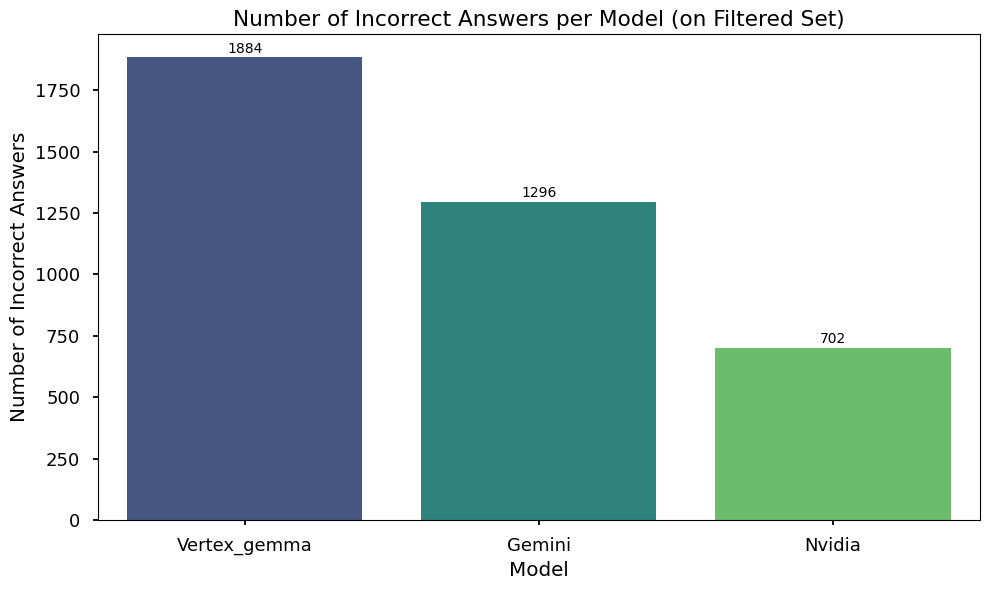

In [9]:
if not incorrect_df.empty:
    print("\nGenerating Visualizations...")
    plt.style.use('seaborn-v0_8-talk') # Use a visually appealing style

    # --- Plot 1: Failure Counts per Model ---
    plt.figure(figsize=(10, 6))
    # Use the sorted data from Cell 7
    models = [item[0].capitalize() for item in sorted_failures]
    counts = [item[1] for item in sorted_failures]
    sns.barplot(x=models, y=counts, palette='viridis')
    plt.title('Number of Incorrect Answers per Model (on Filtered Set)')
    plt.ylabel('Number of Incorrect Answers')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    # Add counts on top of bars
    for index, value in enumerate(counts):
        plt.text(index, value + max(counts)*0.01 , str(value), ha='center') # Adjust vertical position slightly
    plt.tight_layout()
    plt.show()

/var/folders/t2/64zmxnp511vdl4pwg5frfck40000gn/T/ipykernel_61308/4274997320.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=overlap_data, x='num_models_incorrect', y='count', palette='magma')


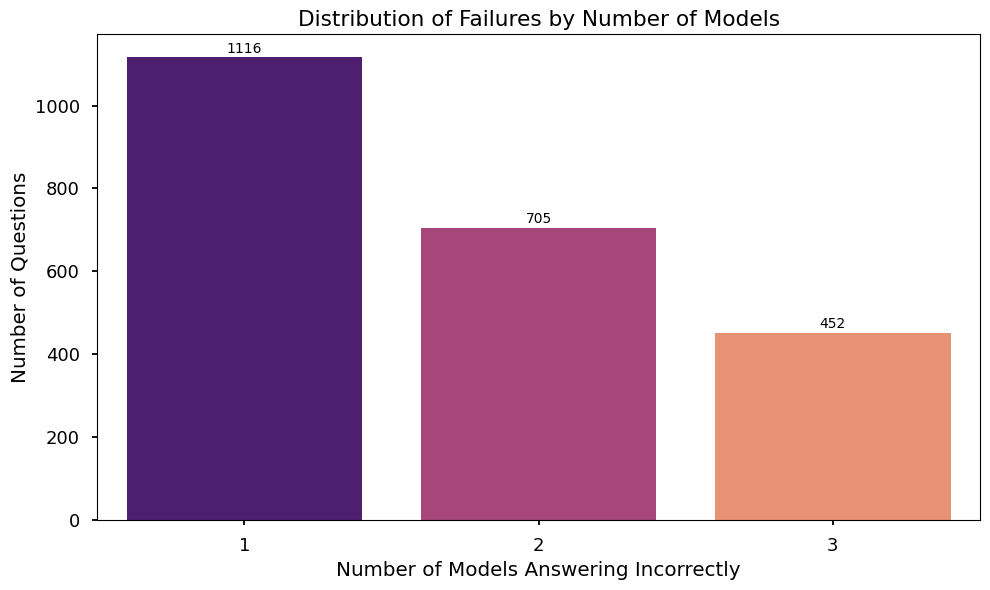

In [10]:
plt.figure(figsize=(10, 6))
overlap_data = overlap_counts.reset_index()
overlap_data.columns = ['num_models_incorrect', 'count']
sns.barplot(data=overlap_data, x='num_models_incorrect', y='count', palette='magma')
plt.title('Distribution of Failures by Number of Models')
plt.xlabel('Number of Models Answering Incorrectly')
plt.ylabel('Number of Questions')
# Add counts on top of bars
for index, row in overlap_data.iterrows():
        plt.text(index, row['count'] + overlap_data['count'].max()*0.01, str(row['count']), ha='center')
plt.tight_layout()
plt.show()

/var/folders/t2/64zmxnp511vdl4pwg5frfck40000gn/T/ipykernel_61308/2806716048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dataset_failure_counts.index, y=dataset_failure_counts.values, palette='crest')


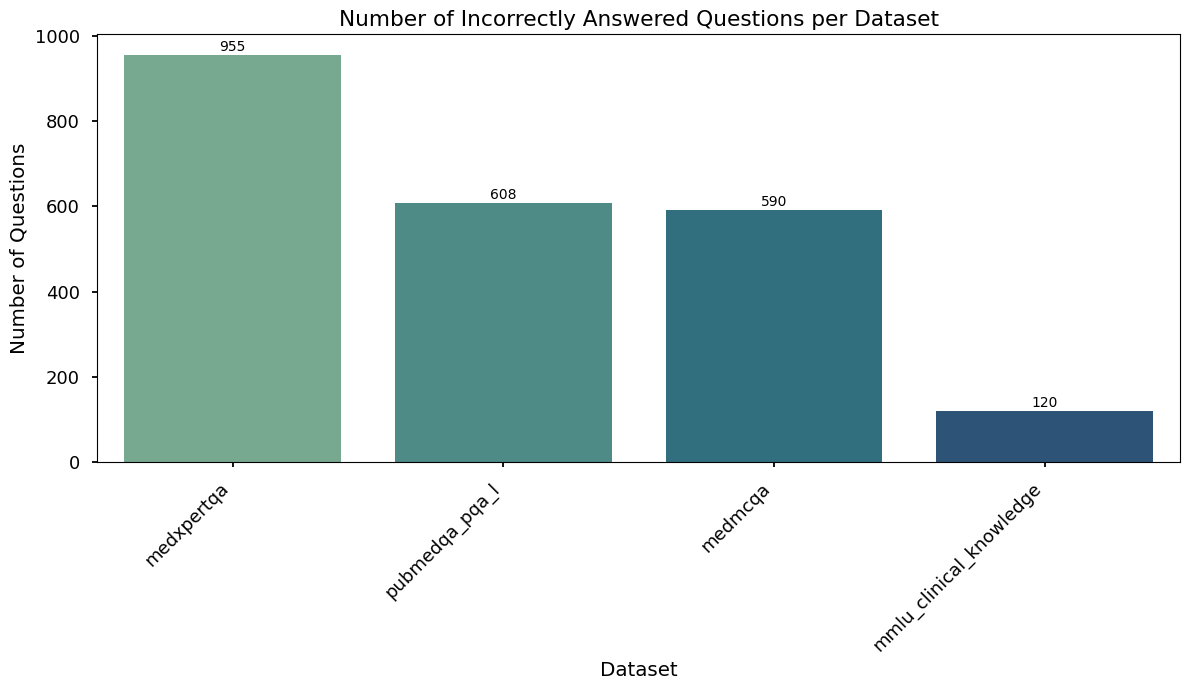

In [11]:
plt.figure(figsize=(12, 7))
dataset_failure_counts = incorrect_df['dataset'].value_counts()
sns.barplot(x=dataset_failure_counts.index, y=dataset_failure_counts.values, palette='crest')
plt.title('Number of Incorrectly Answered Questions per Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45, ha='right')
# Add counts on top of bars
for index, value in enumerate(dataset_failure_counts.values):
    plt.text(index, value + dataset_failure_counts.values.max()*0.01, str(value), ha='center')
plt.tight_layout()
plt.show()

/var/folders/t2/64zmxnp511vdl4pwg5frfck40000gn/T/ipykernel_61308/2991630469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combination_counts.index, y=combination_counts.values, palette='rocket')


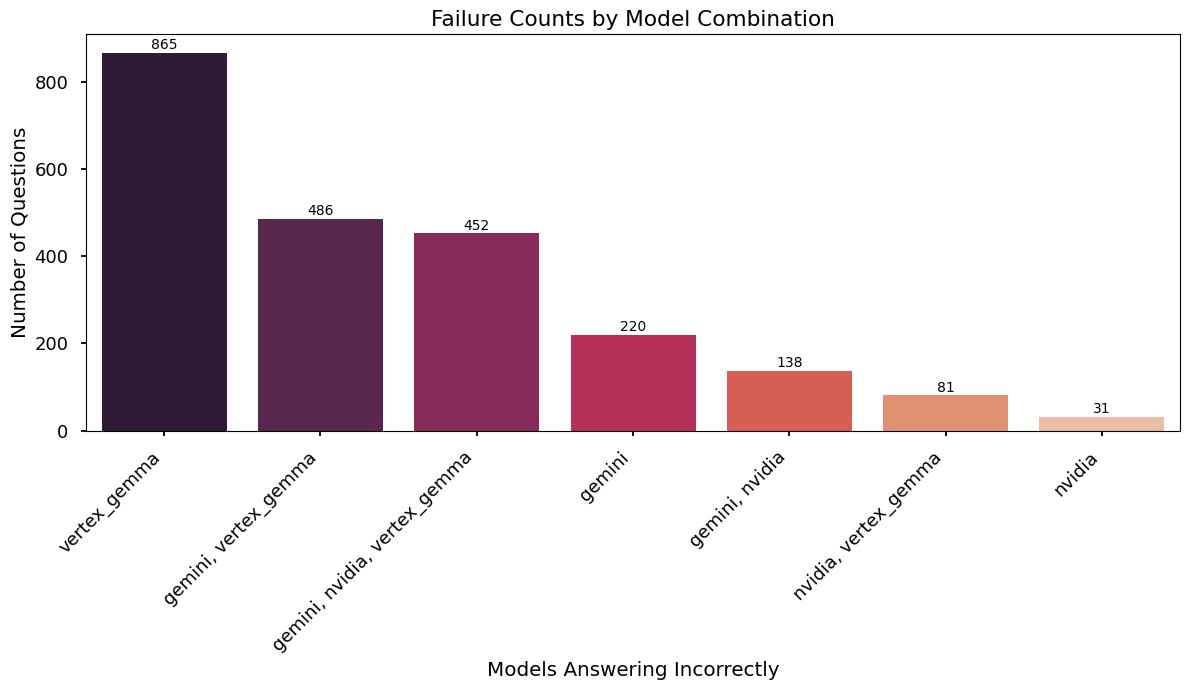

In [12]:
if len(combination_counts) < 15: # Only plot if combinations are manageable
    plt.figure(figsize=(12, 7))
    sns.barplot(x=combination_counts.index, y=combination_counts.values, palette='rocket')
    plt.title('Failure Counts by Model Combination')
    plt.xlabel('Models Answering Incorrectly')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45, ha='right')
    # Add counts on top of bars
    for index, value in enumerate(combination_counts.values):
        plt.text(index, value + combination_counts.values.max()*0.01, str(value), ha='center')
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping Failure Combination plot (too many combinations).")
    print("Consider using an UpSet plot for better visualization of intersections.")
    # Example placeholder for UpSet plot if you install the library
    # try:
    #     from upsetplot import plot
    #     # Create data suitable for upsetplot (e.g., multi-index boolean series)
    #     # ... data preparation ...
    #     # plot(data_for_upset)
    #     # plt.show()
    # except ImportError:
    #     print("Hint: `pip install upsetplot` to generate UpSet plots for intersections.")


In [13]:
if not incorrect_df.empty:
    print("\n--- Further Exploration Examples ---")

    # 1. Questions where ONLY Vertex Gemma failed
    only_vertex_fail = incorrect_df[incorrect_df['models_incorrect_list'] == 'vertex_gemma']
    print(f"\nFound {len(only_vertex_fail)} questions where ONLY Vertex Gemma failed.")
    if not only_vertex_fail.empty:
        print("Sample Questions (Only Vertex Gemma Incorrect):")
        display(only_vertex_fail[['dataset', 'id', 'question', 'ground_truth_answer', 'vertex_gemma_parsed']].head())

    # 2. Questions where ONLY NVIDIA failed
    only_nvidia_fail = incorrect_df[incorrect_df['models_incorrect_list'] == 'nvidia']
    print(f"\nFound {len(only_nvidia_fail)} questions where ONLY NVIDIA failed.")
    if not only_nvidia_fail.empty:
        print("Sample Questions (Only NVIDIA Incorrect):")
        display(only_nvidia_fail[['dataset', 'id', 'question', 'ground_truth_answer', 'nvidia_parsed']].head())

    # 3. Questions where ONLY Gemini failed
    only_gemini_fail = incorrect_df[incorrect_df['models_incorrect_list'] == 'gemini']
    print(f"\nFound {len(only_gemini_fail)} questions where ONLY Gemini failed.")
    if not only_gemini_fail.empty:
        print("Sample Questions (Only Gemini Incorrect):")
        display(only_gemini_fail[['dataset', 'id', 'question', 'ground_truth_answer', 'gemini_parsed']].head())

    # 4. Compare parsed answers on questions where ALL models failed
    if not all_fail_df.empty:
        print("\nParsed Answers Comparison (Where ALL models failed):")
        display(all_fail_df[['dataset', 'id', 'ground_truth_answer', 'gemini_parsed', 'nvidia_parsed', 'vertex_gemma_parsed']].head())


--- Further Exploration Examples ---

Found 865 questions where ONLY Vertex Gemma failed.
Sample Questions (Only Vertex Gemma Incorrect):


,dataset,id,question,ground_truth_answer,vertex_gemma_parsed
0,mmlu_clinical_knowledge,index_102,"A 67-year-old man, three hours post-transureth...",B,A
1,mmlu_clinical_knowledge,index_106,The sex of a child is dictated by the inherita...,D,A
2,mmlu_clinical_knowledge,index_107,Which of the following is true in spastic para...,A,C
3,mmlu_clinical_knowledge,index_108,"The synthesis of glucose from lactate, glycero...",D,A
5,mmlu_clinical_knowledge,index_113,Which of the following is the same strength as...,A,D



Found 31 questions where ONLY NVIDIA failed.
Sample Questions (Only NVIDIA Incorrect):


,dataset,id,question,ground_truth_answer,nvidia_parsed
44,mmlu_clinical_knowledge,index_207,Which of the following is recommended for clea...,B,D
56,mmlu_clinical_knowledge,index_235,The blood glucose concentration during 80-90 m...,A,B
105,mmlu_clinical_knowledge,index_70,Removal of adhesive strips:,A,B
174,medmcqa,24b17b1d-0dac-4da1-b215-22451784b9b6,Lymph vessel which drain the posterior 1/3 rd ...,A,D
306,medxpertqa,Text-95,A 6-year-old boy is brought to the physician b...,F,C



Found 220 questions where ONLY Gemini failed.
Sample Questions (Only Gemini Incorrect):


,dataset,id,question,ground_truth_answer,gemini_parsed
16,mmlu_clinical_knowledge,index_137,Which of these is most likely to cause deviati...,C,A
58,mmlu_clinical_knowledge,index_240,Approximately how many kJ of energy are expend...,C,A
73,mmlu_clinical_knowledge,index_12,Which of the following statements is false?,B,D
113,mmlu_clinical_knowledge,index_83,Dopamine is prescribed at a rate of 4 microgra...,B,A
169,medmcqa,f79a972f-3611-4cdc-837e-ce2f9393f592,Hyper viscosity is seen in,A,B



Parsed Answers Comparison (Where ALL models failed):


,dataset,id,ground_truth_answer,gemini_parsed,nvidia_parsed,vertex_gemma_parsed
4,mmlu_clinical_knowledge,index_111,C,D,D,A
18,mmlu_clinical_knowledge,index_141,C,D,D,B
20,mmlu_clinical_knowledge,index_147,B,A,A,A
59,mmlu_clinical_knowledge,index_241,B,A,C,C
67,mmlu_clinical_knowledge,index_262,D,B,B,A
